In [1]:
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1
!pip install xgboost
!pip install -q --no-deps numerai-tools



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 532.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 65.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not insta

In [ ]:
prubas

In [ ]:
from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

In [ ]:
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("availbable", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v4.3', 'v5.0', 'v4.2', 'v4.1', 'v4']
availbable v4.3 files:
 ['v4.3/features.json', 'v4.3/live_benchmark_models.parquet', 'v4.3/live_example_preds.csv', 'v4.3/live_example_preds.parquet', 'v4.3/live_int8.parquet', 'v4.3/meta_model.parquet', 'v4.3/train_benchmark_models.parquet', 'v4.3/train_int8.parquet', 'v4.3/validation_benchmark_models.parquet', 'v4.3/validation_example_preds.csv', 'v4.3/validation_example_preds.parquet', 'v4.3/validation_int8.parquet']


In [ ]:
napi.download_dataset(f"{DATA_VERSION}/features.json");

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

v4.3/features.json: 1.12MB [00:00, 1.32MB/s]                           

feature_stats 2376
feature_sets 17
targets 41


In [ ]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

feature_set = feature_sets["medium"]

small 42
medium 705
all 2376


In [ ]:
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")

napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet")


# Download and join in the meta_model for the validation eras
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")

# napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")


v4.3/train_int8.parquet: 2.10GB [04:19, 8.09MB/s]                            
v4.3/validation_int8.parquet: 2.61GB [04:06, 10.6MB/s]                            
v4.3/meta_model.parquet: 28.2MB [00:02, 9.66MB/s]                            


'v4.3/meta_model.parquet'

# Dataset entrenamiento

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

len(train)

2420521

In [ ]:
train = train[train["era"].isin(train["era"].unique()[::4])]
len(train)

606176

In [ ]:
nan = train.isna().sum()
columns_with_nan = nan[nan > 0].index

# Visualizar las columnas con NaN
print("Columnas con NaN:")
print(columns_with_nan)

Columnas con NaN:
Index([], dtype='object')


<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

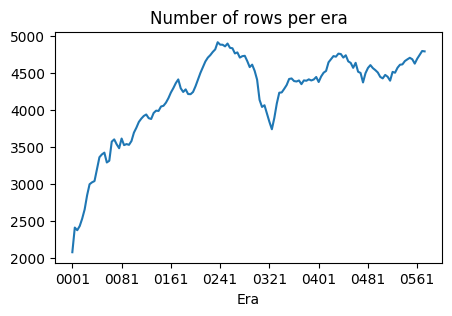

In [ ]:
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

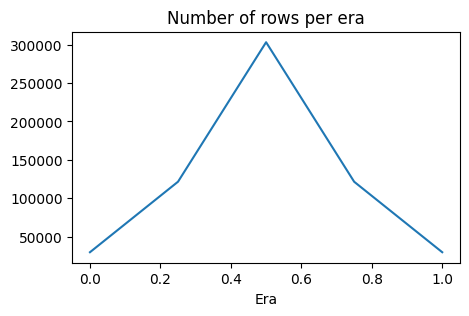

In [ ]:
train.groupby("target").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

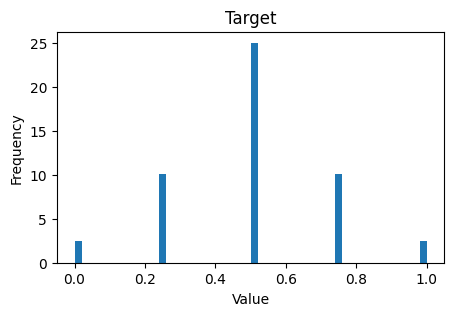

In [ ]:
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

# Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import  RandomizedSearchCV

In [ ]:
model = LinearRegression()




In [ ]:
model.fit(
  train[feature_set],
  train["target"]
)

LinearRegression()

In [ ]:
def calcular_metricas(model,random_search, nombre_modelo):

  results = random_search.cv_results_

  validation = pd.read_parquet(
      f"{DATA_VERSION}/validation_int8.parquet",
      columns=["era", "data_type", "target"] + feature_set
  )
  validation = validation[validation["data_type"] == "validation"]
  del validation["data_type"]

  # Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
  # Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
  validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

  # Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
  # so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
  last_train_era = int(train["era"].unique()[-1])
  eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
  validation = validation[~validation["era"].isin(eras_to_embargo)]

  # Generate predictions against the out-of-sample validation features
  # This will take a few minutes 🍵
  validation["prediction"] = model.predict(validation[feature_set])
  validation[["era", "prediction", "target"]]

  validation.to_csv(nombre_modelo+".csv")





  #Metricas estándar
  y_test = validation["target"]

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  print(f'Mean Absolute Error (MAE): {mae}')
  print(f'Mean Squared Error (MSE): {mse}')

  #Métricas Numerai

  validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]


  per_era_corr = validation.groupby("era").apply(
      lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
  )

  # Compute the per-era mmc between our predictions, the meta model, and the target values
  per_era_mmc = validation.dropna().groupby("era").apply(
      lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
  )


  # Plot the per-era correlation
  per_era_corr.plot(
    title="Validation CORR",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
    snap=False
  )
  per_era_mmc.plot(
    title="Validation MMC",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
    snap=False
  )
  per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
  per_era_mmc.cumsum().plot(
    title="Cumulative Validation MMC",
    kind="line",
    figsize=(8, 4),
    legend=False
  )


In [ ]:
y_pred = model.predict(validation[feature_set])

y_test = validation["target"]

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 0.1546613513989605
Mean Squared Error (MSE): 0.049854946717345146


In [ ]:
def calculate_metrics(group):
    y_true = group['target']
    y_pred = group['prediction']

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)


    return pd.Series({
        'MAE': mae,
        'MSE': mse,

    })

In [ ]:
metrics_by_era = validation.groupby('era').apply(calculate_metrics).reset_index()
print(metrics_by_era)

      era       MAE       MSE
0    0579  0.154149  0.049728
1    0583  0.154435  0.049785
2    0587  0.155436  0.050218
3    0591  0.154445  0.049961
4    0595  0.154417  0.049834
..    ...       ...       ...
130  1099  0.154884  0.049911
131  1103  0.154497  0.049609
132  1107  0.154805  0.049760
133  1111  0.155002  0.049996
134  1115  0.154313  0.049808

[135 rows x 3 columns]


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

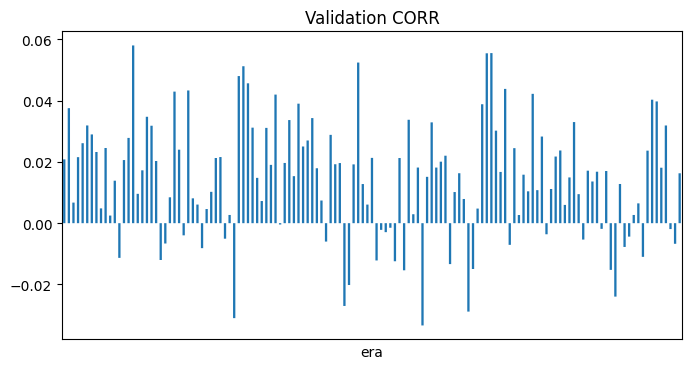

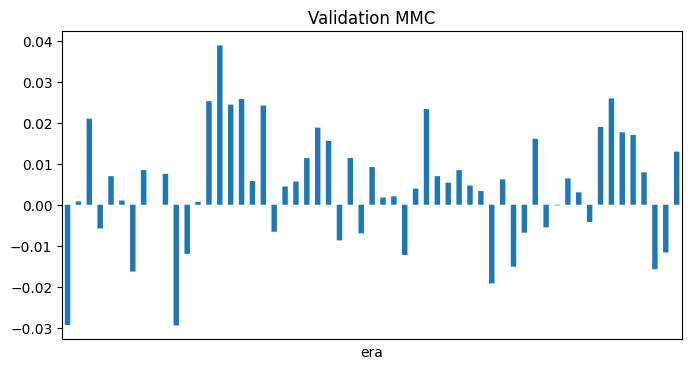

In [ ]:
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]


per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

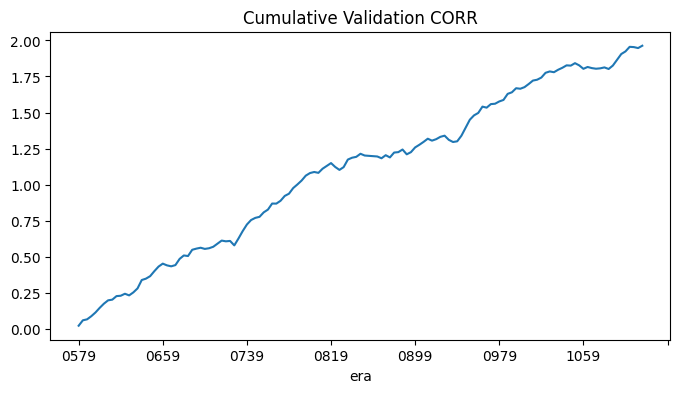

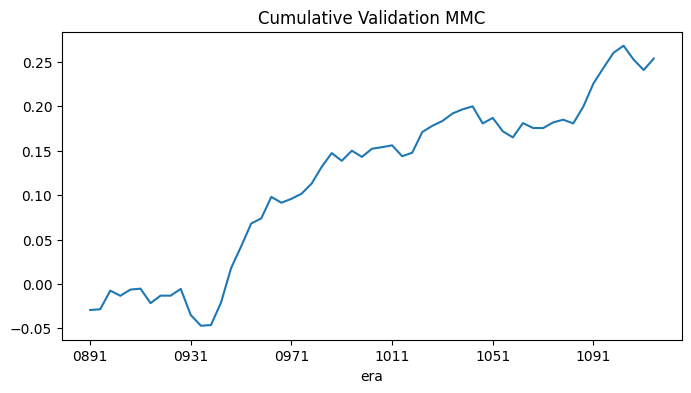

In [ ]:
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)




# RamdonForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(random_state=42)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_distributions = {
    'n_estimators': [50,],  # Número de árboles en el bosque
    # 'max_depth': [None, 10, 20, 30, 50],  # Profundidad máxima de los árboles
    # 'min_samples_split': [5],  # Número mínimo de muestras requeridas para dividir un nodo
    # 'min_samples_leaf': [ 4],  # Número mínimo de muestras requeridas en cada hoja del árbol
    #'max_features': ['auto', 'sqrt', 'log2']  # Número máximo de características a considerar en cada división
}


In [ ]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=1,  # Número de combinaciones aleatorias a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Número de pliegues de validación cruzada
    random_state=42,
    n_jobs=-1,  # Utiliza todos los núcleos disponibles
    verbose=2
)

In [ ]:
random_search.fit(
  train[feature_set],
  train["target"]
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [ ]:
results = random_search.cv_results_

# Convertir los resultados en un DataFrame para ver las métricas de los modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rank_test_score')  # Ordenar por el mejor puntaje

# Mostrar las columnas relevantes (hiperparámetros y métricas)
relevant_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(results_df[relevant_columns])

# SARIMAX

In [ ]:
from sklearn.base import BaseEstimator
class SARIMAXWrapper(BaseEstimator):
    def __init__(self, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y=None):
        endog = X["target"]
        exog = X[feature_set]
        self.model = SARIMAX(endog=endog, exog=exog, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        exog = X[feature_set]
        return self.model_fit.predict(exog=exog)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_distributions = {
    'order': [(1, 0, 0), (0, 1, 0), (1, 1, 0)],  # Combinaciones de parámetros p, d, q para ARIMA
    'seasonal_order': [(1, 0, 0, 12), (0, 1, 0, 12)],  # Combinaciones de parámetros P, D, Q, S para SARIMA
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=SARIMAXWrapper(),
    param_distributions=param_distributions,
    n_iter=5,  # Número de combinaciones aleatorias a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Número de pliegues de validación cruzada
    random_state=42,
    n_jobs=-1  # Utiliza todos los núcleos disponibles
)

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(train)

# Obtener los mejores hiperparámetros y evaluar el modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(validation)
mse = mean_squared_error(validation["target"], y_pred)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "<ipython-input-61-7696a2b2aec9>", line 11, in fit
NameError: name 'SARIMAX' is not defined


# XGBOOST

In [ ]:
X= train[feature_set]
Y =train["target"]
params = {
        # 'min_child_weight': [1, 5, 10],
        # 'gamma': [0.5, 1, 1.5, 2, 5],
        # 'subsample': [0.6, 0.8, 1.0],
        # 'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [100],
        'n_estimators':[100]
        }

xgb =XGBRegressor(learning_rate=0.05,  device="cuda")

In [ ]:
olds = 3
param_comb = 20


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,scoring='neg_mean_absolute_error',   n_jobs=-1,  verbose=2 )

In [ ]:
random_search.fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
results = random_search.cv_results_

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rank_test_score')

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1538.141709,1224.065377,1.400059,1.144269,100,100,"{'n_estimators': 100, 'max_depth': 100}",-0.170511,-0.171167,NaN,-0.17333,NaN,NaN,NaN,1


In [ ]:
relevant_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(results_df[relevant_columns])

                                    params  mean_test_score  std_test_score  \
0  {'n_estimators': 100, 'max_depth': 100}              NaN             NaN   

   rank_test_score  
0                1  


In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(validation[feature_set])

y_test = validation["target"]

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 0.15062254667282104
Mean Squared Error (MSE): 0.04976848512887955


In [ ]:
y_pred.max()

0.51755273

In [ ]:
ranked_preds = (y_pred.rank(method="average").values - 0.5) / y_pred.count()
# gauss_ranked_preds = stats.norm.ppf(ranked_preds)

#   # make targets centered around 0
# centered_target = target - target.mean()

#   # raise both preds and target to the power of 1.5 to accentuate the tails
# preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
# target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5

AttributeError: 'numpy.ndarray' object has no attribute 'rank'

In [ ]:
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

per_era_corr

,prediction
era,
0579,NaN
0583,NaN
0587,NaN
0591,NaN
0595,NaN
...,...
1099,NaN
1103,NaN
1107,NaN


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

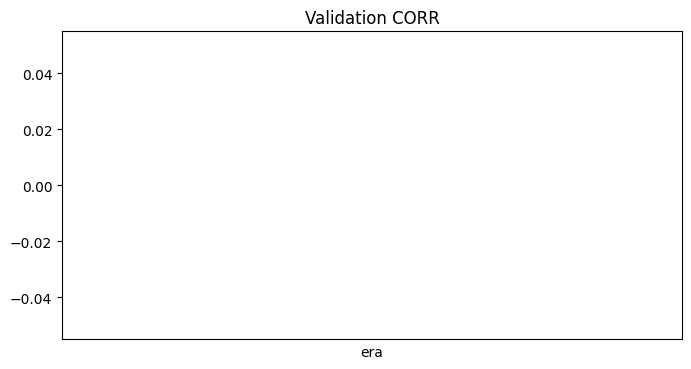

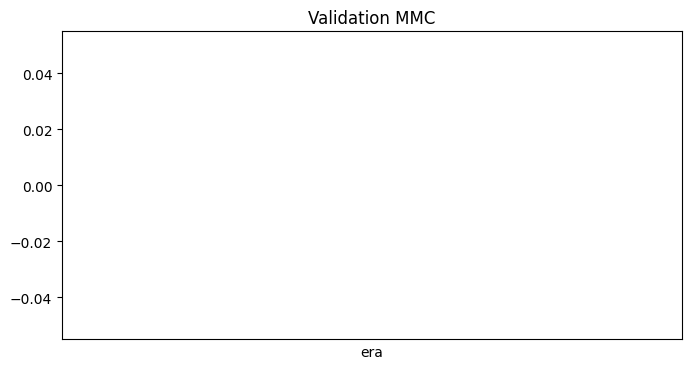

In [ ]:
validation = pd.read_parquet(
      f"{DATA_VERSION}/validation_int8.parquet",
      columns=["era", "data_type", "target"] + feature_set
  )
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = best_model.predict(validation[feature_set])

validation["meta_model"] = pd.read_parquet(
  f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]


per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

# LightGBM

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

# This will take a few minutes 🍵
model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 705
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

# ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def build_model(units_1=32, units_2=32, optimizer='adam'):
    model = Sequential()
    model.add(Dense(units=units_1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=units_2, activation='relu'))
    model.add(Dense(units=1))  # Capa de salida para regresión

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrapping del modelo Keras para usar con RandomizedSearchCV
keras_regressor = KerasRegressor(build_fn=build_model, verbose=0)

# Definir la cuadrícula de parámetros para la búsqueda aleatoria
param_distributions = {
    'units_1': [16, 32, 64],  # Número de unidades en la primera capa oculta
    'units_2': [16, 32, 64],  # Número de unidades en la segunda capa oculta
    'optimizer': ['adam']  # Optimizador a probar
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=param_distributions,
    n_iter=5,  # Número de combinaciones aleatorias a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Número de pliegues de validación cruzada
    random_state=42,
    n_jobs=-1  # Utiliza todos los núcleos disponibles
)

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train, epochs=50, verbose=0)

# Obtener los mejores hiperparámetros y evaluar el modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Mean Squared Error (MSE): {mse}')